In [1]:
import pybedtools as pbt
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy import stats
from Bio import Align, SeqIO, Seq
import numpy as np
from collections import defaultdict
import treeswift as ts

pd.set_option('display.max_rows', 150)

In [2]:
taxdict = {}
taxonomy_tree = ts.read_tree_newick('../data/metazoa_phylum.nwk')

target_taxa = [i.label for i in taxonomy_tree.traverse_leaves()]
taxdict = {}
with open('../data/species_taxonomy.txt') as infile:
    for line in infile:
        line = [i.strip('\t').strip() for i in line.strip().split('|')][:-1]
        species = '_'.join(line[1].split(' '))
        lineage = [i.strip() for i in line[2].split(';')][:-1]
        taxdict[species] = lineage
for species, lineage in taxdict.items():
    for tax in target_taxa:
        if tax in lineage:
            taxdict[species] = tax
            break
        else:
            taxdict[species] = 'NA'
metadata_df = pd.read_csv('../data/parsed_metazoans.out', 
                          sep='\t', 
                          header=None, 
                          names=['species', 'genome', 'ftpdir', 'scaffold_n50', 'assembly_status']) \
                .drop(['ftpdir', 'genome'], axis=1)
metadata_df['genus'] = metadata_df['species'].apply(lambda x: x.split('_')[0])
metadata_df['taxonomy'] = metadata_df.species.apply(lambda x: taxdict.get(x, 'Other'))
metadata_df = metadata_df.loc[metadata_df.scaffold_n50 > 1e06]

znf_counts = []
for species in metadata_df.iterrows():
    try:
        znf_bed = pbt.BedTool(f'../data/beds/{species[1].species}_znfs.bed')
    except:
        print(f'{species[1].species} missing')
        
    for row in znf_bed:
        znf_counts.append((species[1].species, species[1].taxonomy, species[1].assembly_status, species[1].scaffold_n50, int(row[4])))
znf_count_df = pd.DataFrame(znf_counts, columns=['species', 'taxonomy', 'assembly_status', 'scaffold_n50', 'znf_count'])
print(znf_count_df)

Ambystoma_mexicanum missing
Muntiacus_muntjak missing
Neoceratodus_forsteri missing
Protopterus_annectens missing
                     species    taxonomy assembly_status  scaffold_n50  \
0       Abrostola_tripartita  Arthropoda      Chromosome      13645312   
1       Abrostola_tripartita  Arthropoda      Chromosome      13645312   
2       Abrostola_tripartita  Arthropoda      Chromosome      13645312   
3       Abrostola_tripartita  Arthropoda      Chromosome      13645312   
4       Abrostola_tripartita  Arthropoda      Chromosome      13645312   
...                      ...         ...             ...           ...   
614356          Mus_musculus    Chordata      Chromosome     106145001   
614357          Mus_musculus    Chordata      Chromosome     106145001   
614358          Mus_musculus    Chordata      Chromosome     106145001   
614359          Mus_musculus    Chordata      Chromosome     106145001   
614360          Mus_musculus    Chordata      Chromosome     106145001  

In [3]:
hiqual_df = znf_count_df.groupby(['species', 'taxonomy', 'assembly_status', 'scaffold_n50']).count().reset_index()
hiqual_df = hiqual_df.loc[(hiqual_df.assembly_status == 'Chromosome') & (hiqual_df.scaffold_n50 > 1e6) & (hiqual_df.znf_count >= 500)].sort_values('znf_count')
print(hiqual_df.head())
print(hiqual_df.loc[hiqual_df.species == 'Octopus_sinensis'])

                    species  taxonomy assembly_status  scaffold_n50  znf_count
267         Bubalus_bubalis  Chordata      Chromosome     116997125        501
1024      Muntiacus_muntjak  Chordata      Chromosome     682452208        501
190   Balaenoptera_musculus  Chordata      Chromosome     110314666        501
244              Bos_taurus  Chordata      Chromosome     103308737        501
1053       Nasalis_larvatus  Chordata      Chromosome     137426304        501
               species  taxonomy assembly_status  scaffold_n50  znf_count
1105  Octopus_sinensis  Mollusca      Chromosome     105892736       2244


We would like to be able to visualise the distribution of zinc finger ORFs across chromosomes. This reveals some interesting patterns

In [4]:
def chrom_znf_counts(species, minznfs=50):
    znf_chrom_dict = defaultdict(int)
    i = 0
    with open(f'../data/beds/{species}_znfs.bed') as infile:
        for line in infile:
            line = line.strip().split('\t')
            line[3] += f'-{i}'
            znf_chrom_dict[line[0]] += 1
            i += 1
    znf_chrom = sorted(znf_chrom_dict.items(), key=lambda x: x[1])[-2][0]
    return pd.DataFrame(znf_chrom_dict.items(), 
                        columns=['chrom', 'znf_count']) \
             .sort_values('znf_count',
                          ascending=False) \
             .reset_index(drop=True)
    
def get_alignment_identity(ali):
    a1, a2 = str(ali).split('\n')[0], str(ali).split('\n')[2]
    return 100*len([val for (i, val) in enumerate(a1) if val == a2[i]])/len(a1)

def align_seqs(seqs):
    aligner = Align.PairwiseAligner()
    aligner.mode = 'global'
    aligner.substitution_matrix = Align.substitution_matrices.load("BLOSUM62")
    
    pairwise_identity_dict = {}
    for i, seqa in enumerate(seqs):
        for j, seqb in enumerate(seqs):
            if i >= j:
                continue
            ali = aligner.align(seqa.seq.translate(), seqb.seq.translate())[0]
            pairwise_identity_dict[(seqa.name, seqb.name)] = get_alignment_identity(ali)
    
    return pairwise_identity_dict

def get_pairwise_alignments(species, same_chrom=True):
    
    def chrom(seq):
        return seq.name.split(':')[0]
    
    aligner = Align.PairwiseAligner()
    aligner.mode = 'global'
    aligner.substitution_matrix = Align.substitution_matrices.load("BLOSUM62")
    
    pair_pids = {}
    for i, seqa in enumerate(SeqIO.parse(f'../data/seqs/{species}_znfs.fa', 'fasta')):
        for j, seqb in enumerate(SeqIO.parse(f'../data/seqs/{species}_znfs.fa', 'fasta')):
            if i >= j:
                continue
            if same_chrom == True and chrom(seqa) != chrom(seqb):
                continue
            
            ali = aligner.align(seqa.seq.translate(), seqb.seq.translate())[0]
            pid = get_alignment_identity(ali)
            pair_pids[(seqa.id, seqb.id)] = pid
    return pair_pids
                    
def generate_position_matrix(species, chromosome, window=1e4):
    
    def label(bedline):
        return f'{bedline[0]}:{bedline[1]}-{bedline[2]}({bedline[5]})'
    
    def midpoint(bedline):
        return int(bedline[1]) + int((int(bedline[2]) - int(bedline[1]))/2)
    
    def cell(bedline):
        return int(np.floor(midpoint(bedline)/window))
    
    seqs = SeqIO.to_dict(SeqIO.parse(f'../data/seqs/{species}_znfs.fa', 'fasta'))
    beddata = []
    with open(f'../data/beds/{species}_znfs.bed') as infile:
        for line in infile:
            line = line.strip().split('\t')
            if line[0] != chromosome:
                continue
            beddata.append(line)

    with open(f'../data/genomes/{species}.genome') as infile:
        for line in infile:
            line = line.strip().split('\t')
            if line[0] == chromosome:
                chromsize = int(line[1])
                break
    ncells = int(np.floor(chromsize/window))
    matrix = np.zeros((ncells, ncells))
    
    aligner = Align.PairwiseAligner()
    aligner.mode = 'global'
    aligner.substitution_matrix = Align.substitution_matrices.load("BLOSUM62")
    
    for i, linea in enumerate(beddata):
        for j, lineb in enumerate(beddata):
            if i > j:
                continue
            seqa, seqb = seqs[label(linea)], seqs[label(lineb)]
            cella, cellb = cell(linea), cell(lineb)
            if i == j:
                matrix[cella, cellb] = 100.0
                continue
            ali = aligner.align(seqa.seq.translate(), seqb.seq.translate())[0]
            pid = get_alignment_identity(ali)
            if pid > matrix[cella, cellb]:
                matrix[cella, cellb] = pid
    return matrix

In [5]:
top_chroms = []
for species in hiqual_df.species:
    try:
        top = chrom_znf_counts(species).loc[1]
        top_chroms.append([species, top.chrom, top.znf_count])
    except:
        print(f'{species} not available')
top_chrom_df = pd.DataFrame(top_chroms, columns=['species', 'chrom', 'znf_count']).sort_values('znf_count', ascending=False)
print(hiqual_df.loc[hiqual_df.species == 'Leptobrachium_leishanense'])
print(top_chrom_df.head(50))

Muntiacus_muntjak not available
Ambystoma_mexicanum not available
                       species  taxonomy assembly_status  scaffold_n50  \
884  Leptobrachium_leishanense  Chordata      Chromosome     394693044   

     znf_count  
884       1673  
                                             species              chrom  \
196                                        Bufo_bufo         LR991672.1   
198                                 Octopus_sinensis         CM016885.1   
191                           Carcharodon_carcharias  JAGDEE010000169.1   
201                                     Salmo_trutta         LR584425.1   
181                        Erpetoichthys_calabaricus         LR536436.2   
180                             Polypterus_senegalus         CM029058.1   
200                                  Rana_temporaria         LR991683.1   
177                              Limnephilus_lunatus         OU830595.1   
188                                 Bufo_gargarizans         CM026468.1   
1

CM002888.2


/Users/jonwells/miniconda3/envs/python_env/lib/python3.9/site-packages/Bio/Seq.py:2979: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  warnings.warn(


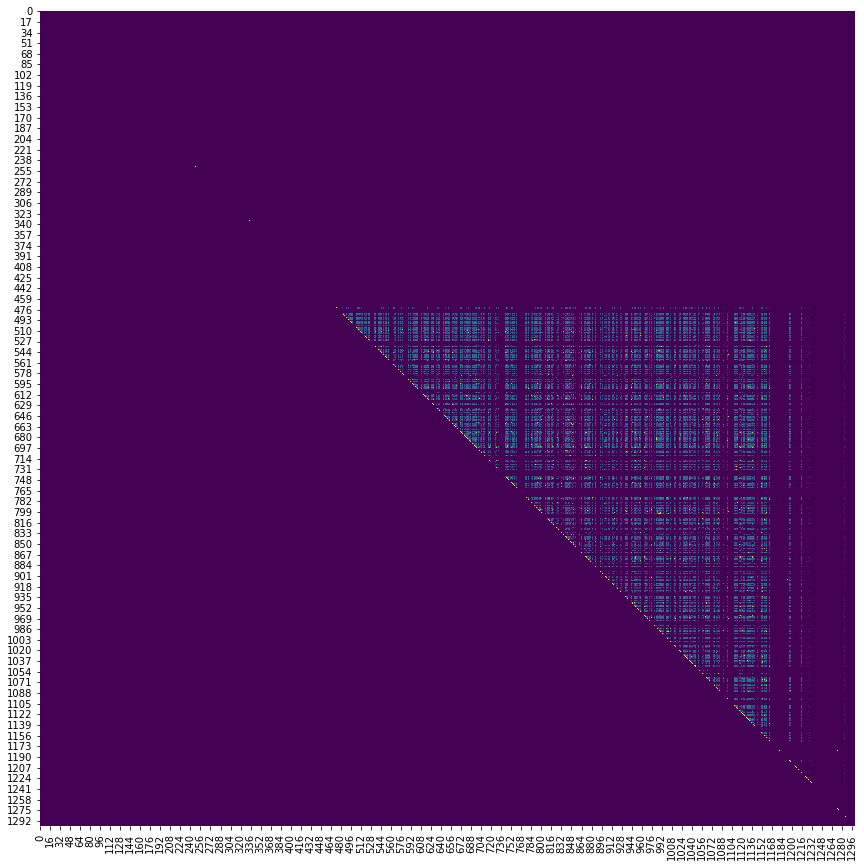

In [10]:
fig, axes = plt.subplots(figsize=(15, 15), nrows=1)
chrom = chrom_znf_counts('Danio_rerio').loc[0, 'chrom']
print(chrom)
posmat = generate_position_matrix('Danio_rerio', chrom, 6e4)
sns.heatmap(posmat, 
            cmap='viridis', 
            cbar=False, 
            vmin=40,
            square=True, 
            ax=axes)
# sns.heatmap(generate_position_matrix('Archivesica_marissinica', chrom_znf_counts('Archivesica_marissinica').loc[0, 'chrom'], 2e4), 
#             cmap='Greys', 
#             cbar=False, 
#             vmin=40, 
#             square=True, 
#             ax=axes[1])
# sns.heatmap(generate_position_matrix('Dolomedes_plantarius', chrom_znf_counts('Dolomedes_plantarius').loc[0, 'chrom'], 2e4), 
#             cmap='Greys', 
#             cbar=False, 
#             vmin=40, 
#             square=True, 
#             ax=axes[2])

plt.show()
fig.savefig('/Users/jonwells/Desktop/Danio_rerio_genomic_distribution.jpeg', dpi=300)

Since it looks like there is some sort of difference in the mechanism of gene duplication, lets see if we can quantify it. We want to do this by seeing if there is

In [7]:
def get_midpoint(label):
    start, stop = (int(i) for i in label.split(':')[1].split('(')[0].split('-'))
    start, stop = min([start, stop]), max([start, stop])
    return np.round(start + (stop - start)/2)

df_data = []
# for species in ['Homo_sapiens', # Human
#                 'Rana_temporaria', # Frog
#                 'Danio_rerio', # Zebrafish
#                 'Scyliorhinus_canicula', # Catshark
#                 'Branchiostoma_floridae', # Florida lancelet
#                 'Nilaparvata_lugens', # Brown planthopper (hemipteran bug)
#                 'Cantharis_rustica', # Soldier beetle
#                 'Sinella_curviseta', # Springtail
#                 'Procambarus_clarkii', # Crayfish
#                 'Argiope_bruennichi', # Wasp spider
#                 'Streblospio_benedicti']: # Tube worm
for species in ['Bibio_marci', # Human
                'Oreochromis_aureus']: # Tube worm

    print(species)
    pid_dict = get_pairwise_alignments(species)
    for key, val in pid_dict.items():
        dist = abs(get_midpoint(key[0]) -  get_midpoint(key[1]))
        df_data.append((key[0], key[1], dist, val, species))
dist_df = pd.DataFrame(df_data, columns=['p1', 'p2', 'distance', 'pid', 'species'])
dist_df['similar'] = False
dist_df.loc[dist_df.pid >= 80.0, 'similar'] = True

Bibio_marci
Oreochromis_aureus


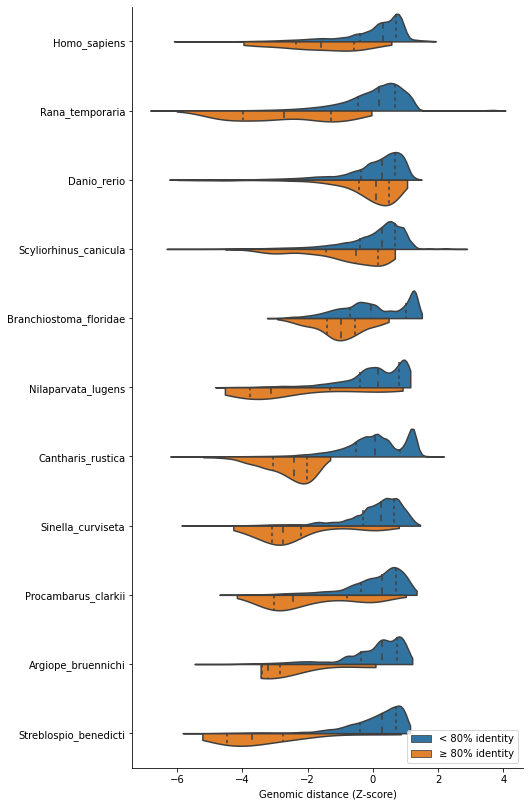

In [8]:
# for species in ['Danio_rerio', 'Homo_sapiens', 'Salmo_trutta', 'Octopus_sinensis', 'Dolomedes_plantarius']:
    # print(species)
dist_df = pd.read_csv('../data/pairwise_identity_distance.tsv', sep='\t')    
dist_df['similar'] = '< 80% identity'
dist_df.loc[dist_df.pid >= 80.0, 'similar'] = '≥ 80% identity'
dist_df['zscore'] = dist_df.groupby('species')['distance'].apply(lambda x: (np.log(x) - np.log(x).mean())/np.log(x).std(ddof=0))
dist_df['log_dist'] = np.log10(dist_df.distance)
fig, ax = plt.subplots(figsize=(7, 14))
sns.violinplot(data=dist_df, 
               x='zscore',
               y='species', 
               hue='similar', ax=ax, split='similar', inner='quartile', cut=0)

# ax.set_xscale('log')
# ax.set_xticklabels(ax.get_xticklabels(), rotation = 65)
plt.legend(loc='lower right')
ax.set_ylabel('')
ax.set_xlabel('Genomic distance (Z-score)')
sns.despine()
plt.show()
fig.savefig('/Users/jonwells/Desktop/multispecies_genomic_distribution.pdf', bbox_inches='tight')

In [101]:
print(stats.ranksums(dist_df.loc[(dist_df.species == 'Homo_sapiens') & (dist_df.similar == True), 'distance'],
                     dist_df.loc[(dist_df.species == 'Homo_sapiens') & (dist_df.similar == False), 'distance']))

RanksumsResult(statistic=-16.1785596746306, pvalue=7.1446297645855e-59)
